# prepare depth prediction

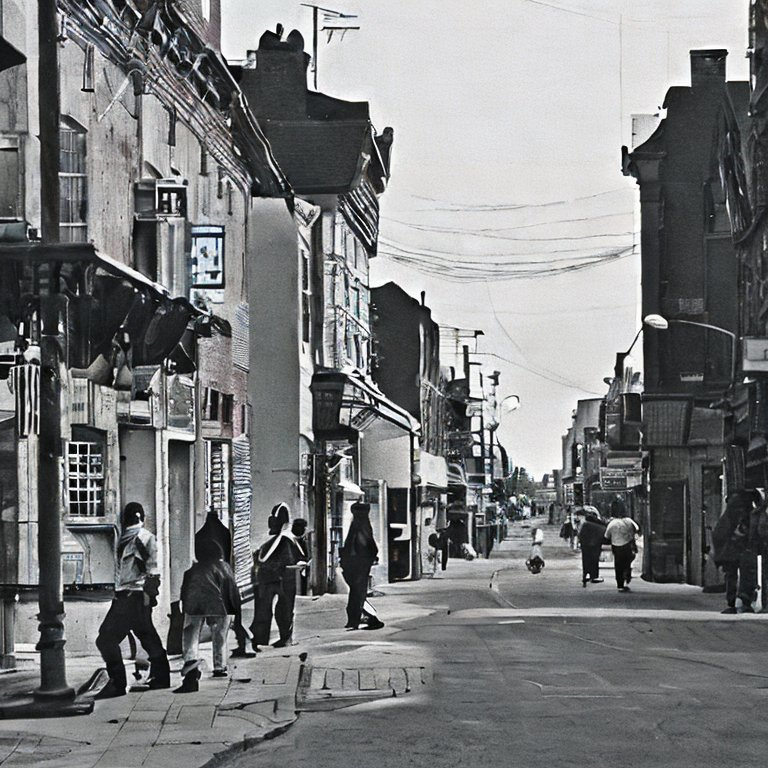

In [2]:
import sys
sys.path.append("/home/wukailu/latent-nerf/src/ControlNet")

ROOT_PATH = '/home/wukailu/latent-nerf/src/ControlNet/'
IMG_PATH = '/home/wukailu/latent-nerf/src/DPT/input/street.jpg'

from PIL import Image
exp = Image.open(IMG_PATH)
exp

In [3]:
import torch
from annotator.util import resize_image, HWC3
from annotator.midas import MidasDetector

apply_midas = MidasDetector()
apply_midas_raw = apply_midas.raw_depth

depth_cap = 10  # the maximum predicted depth
disparity_cap = 1.0 / depth_cap
target_disp_mean = 1.0 / (depth_cap / 5)
target_disp_std = target_disp_mean / 2

def pred_disp(input_image, detect_resolution) -> torch.FloatTensor:
    with torch.no_grad():
        input_image = HWC3(input_image)
        detected_map: torch.FloatTensor = apply_midas(resize_image(input_image, detect_resolution))
    return detected_map[0]

def pred_depth(input_image, detect_resolution) -> torch.FloatTensor:
    with torch.no_grad():
        input_image = HWC3(input_image)
        detected_map: torch.FloatTensor = apply_midas_raw(resize_image(input_image, detect_resolution))
        cur_mean = detected_map.mean()
        cur_std = detected_map.std()
        detected_map = ((detected_map-cur_mean)/cur_std * target_disp_std + target_disp_mean).clip(min=disparity_cap)
        detected_map = 1.0 / detected_map
    return detected_map.cpu()

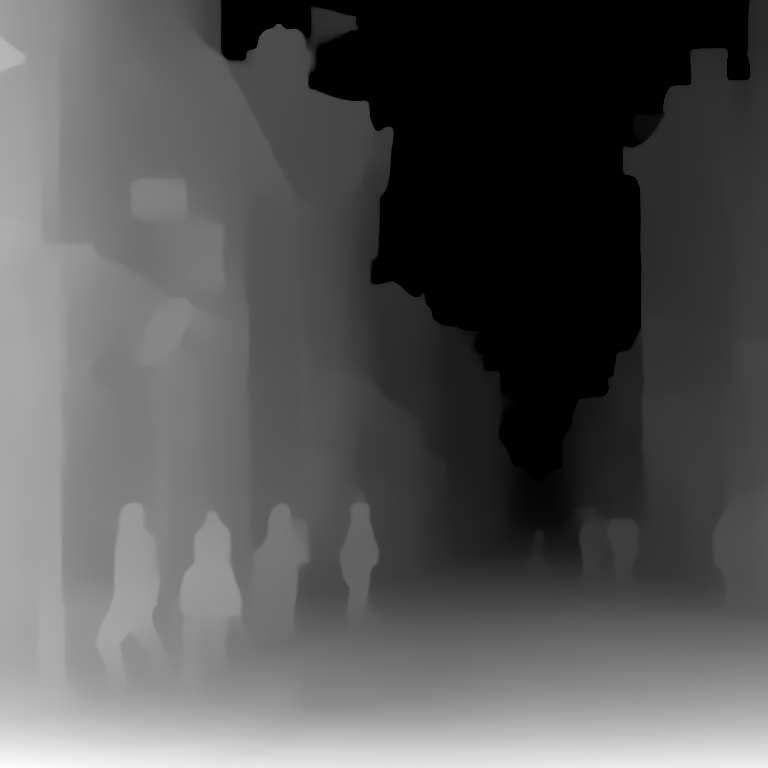

In [4]:
import numpy as np

example_img = np.array(exp)
example_img = example_img[..., :3]
depth = pred_depth(example_img, example_img.shape[0])
disp = pred_disp(example_img, example_img.shape[0])
Image.fromarray(disp)

# depthmap to point cloud

In [5]:
import torch

# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointsRasterizationSettings,
    PointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    ray_bundle_to_ray_points,
    NDCMultinomialRaysampler,
)

# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [6]:
def save_pcd(pcd, path: str):
    assert path.endswith(".ply")
    from pytorch3d.io import IO
    IO().save_pointcloud(pcd, path)
    return pcd

def rgbd_to_pcd(rgb, depth, cameras, mask=None):
    """
    @param masks: boolean tensor of shape [H,W] or None
    """
    xy_depth = depth.to(device)  # results from depth prediction
    # convert the depth maps to point clouds using the grid ray sampler
    ray_bundle = NDCMultinomialRaysampler(
            image_width=depth.shape[1],
            image_height=depth.shape[0],
            n_pts_per_ray=1,
            min_depth=0.1,
            max_depth=depth_cap+1,
        )(cameras)
    ray_bundle = ray_bundle._replace(lengths = depth[None, ..., None].to(device))
    pts_3d = ray_bundle_to_ray_points(ray_bundle)
    if mask is not None:
        pts_3d = pts_3d[mask[None]].view(1,-1,3)
        features = torch.tensor(rgb)[mask].to(device).reshape(1, -1, 3).float()/255.0
    else:
        pts_3d = pts_3d.view(1,-1,3)
        features = torch.tensor(rgb).to(device).reshape(1, -1, 3).float()/255.0

    # Sanity check
    return Pointclouds(points=pts_3d, features=features)

In [7]:
@torch.no_grad()
def pcd_render(cameras, point_cloud, image_size=512, radius = 0.003, points_per_pixel = 5):
    # Define the settings for rasterization and shading. Here we set the output image to be of size
    # 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
    # and blur_radius=0.0. Refer to raster_points.py for explanations of these parameters.
    raster_settings = PointsRasterizationSettings(
        image_size=image_size,
        radius = radius,
        points_per_pixel = points_per_pixel
    )

    # Create a points renderer by compositing points using an alpha compositor (nearer points
    # are weighted more heavily).
    rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
    renderer = PointsRenderer(
        rasterizer=rasterizer,
        compositor=AlphaCompositor(background_color=(0.,0.,0.))
    )
    images_1 = renderer(point_cloud)  # c

    renderer = PointsRenderer(
        rasterizer=rasterizer,
        compositor=AlphaCompositor(background_color=(1.,1.,1.))
    )
    images_2 = renderer(point_cloud)  # c + alpha * 1

    alpha = (images_2 - images_1).clip(min=0)
    return images_1, alpha[..., [0]]

In [20]:
def pcd_inpaint(point_cloud, cameras, prompt="street", num_inference_steps=200, guidance_scale=0, **kwargs):
    """
    @param point_cloud: Pointclouds of pytorch3D
    @param cameras: Type of Cameras in pytorch3D
    """
    from PIL import Image, ImageFilter
    import torch
    from diffusers import DiffusionPipeline
    device = "cuda" if torch.cuda.is_available() else "cpu"
    pipe = DiffusionPipeline.from_pretrained(
        '/home/wukailu/.cache/huggingface/diffusers/cache-runwayml--stable-diffusion-inpainting',
        revision="fp16",
        torch_dtype=torch.float16,
    ).to(device)

    images, alphas = zip(*[pcd_render(cameras[i], point_cloud) for i in range(len(cameras))])  # for cam in camears has bugs
    images, alphas = torch.cat(images), torch.cat(alphas)
    ret = []

    for image, alpha in zip(images, alphas):
        image_pil = Image.fromarray((image.cpu().numpy()*255).round().astype(np.uint8))
        mask_pil = Image.fromarray(((alpha>0.1).float().expand_as(image).cpu().numpy()*255).round().astype(np.uint8))
        blur_pil = mask_pil.filter(ImageFilter.GaussianBlur(radius = 3))
        np_blur = np.array(blur_pil)
        np_blur[np_blur > 20] = 255
        np_blur[np_blur <= 20] = 0
        bin_blur_pil = Image.fromarray(np_blur)
        with torch.cuda.amp.autocast():
            output = pipe(prompt=prompt, image=image_pil, mask_image=bin_blur_pil, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale, **kwargs)
        ret.append(
            {
                "image_pil": image_pil,
                "bin_mask_pil": bin_blur_pil,
                "inpaint_pil": output.images[0]
            }
        )
    return ret

In [21]:
R, T = look_at_view_transform(5, 0, 0)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, znear=0.01, zfar=depth_cap*2)
point_cloud = rgbd_to_pcd(example_img, depth, cameras)

In [22]:
# Create camera for viewing the point clouds
angle_list = [(0, 5), (5, 0), (0, -5), (-5, 0)]
R, T = zip(*[look_at_view_transform(5, angles[0], angles[1]) for angles in angle_list])
R, T = torch.cat(R), torch.cat(T)

view_cameras = FoVPerspectiveCameras(device=device, R=R, T=T, znear=0.01, zfar=depth_cap*2)

In [23]:
results = pcd_inpaint(point_cloud, view_cameras, "street")

/home/wukailu/miniconda3/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

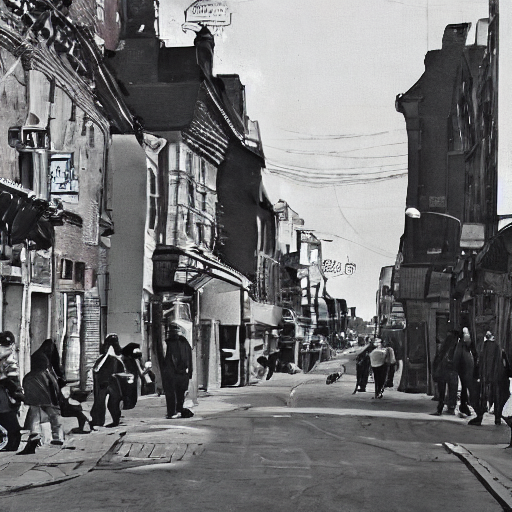

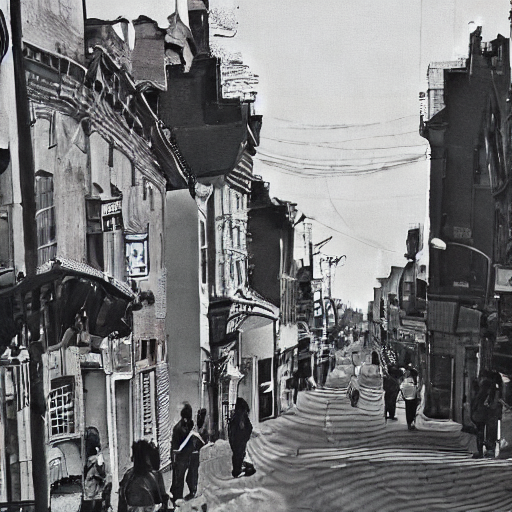

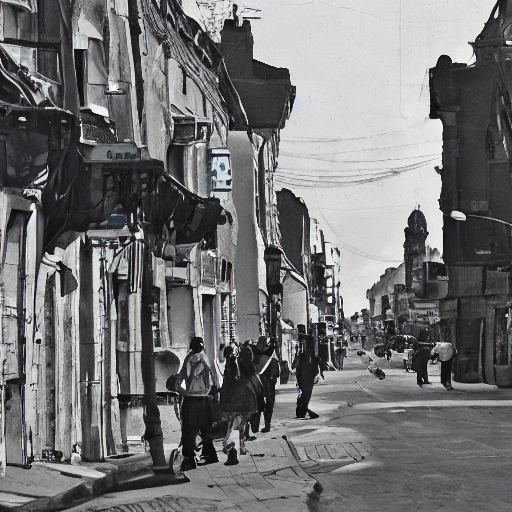

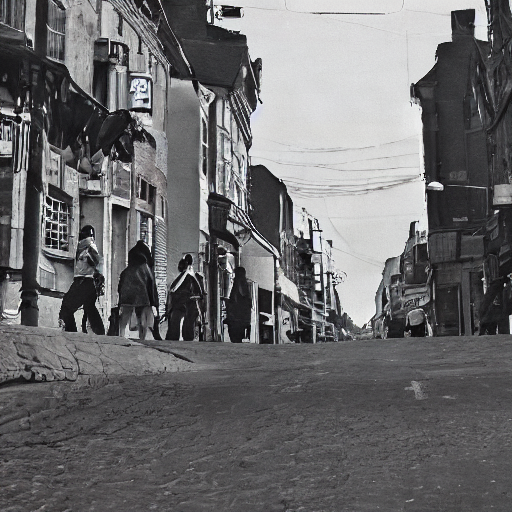

In [24]:
for pil in results:
    display(pil['inpaint_pil'])